# Joss example: NLMOD workflow

---

This example is create for the paper _"xxxxxx"_ that was published in Joss.



### Import Python packages

In [101]:
import nlmod
import flopy as fp
import xarray as xr
import matplotlib.pyplot as plt
from pandas import date_range

nlmod.util.get_color_logger("INFO")

<RootLogger root (INFO)>

### Define spatial properties, name and directories

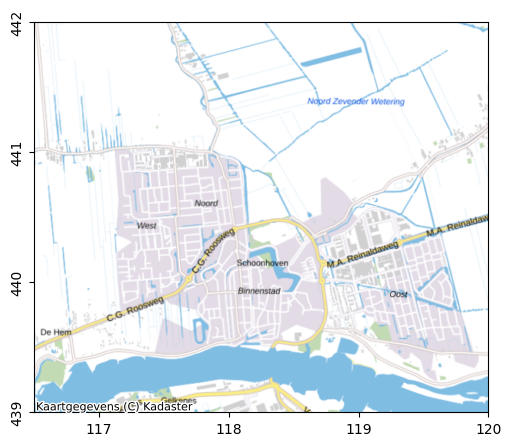

In [ ]:
extent = [116_500, 120_000, 439_000, 442_000]

# set name and directories
model_ws = model_name = 'schoonhoven' # model workspace and modelname
figdir, cachedir = nlmod.util.get_model_dirs(model_ws) # figure and cache directories

# plot map
f, ax = nlmod.plot.get_map(extent, background=True, alpha=1.0, figsize=(5,5))
f.savefig(figdir + f'/{model_name}_map.png')

### Download relevant data

INFO:nlmod.cache.wrapper:using cached data -> regis.nc


INFO:nlmod.cache.decorator:using cached data -> bgt.pklz
INFO:nlmod.cache.wrapper:using cached data -> ahn.nc


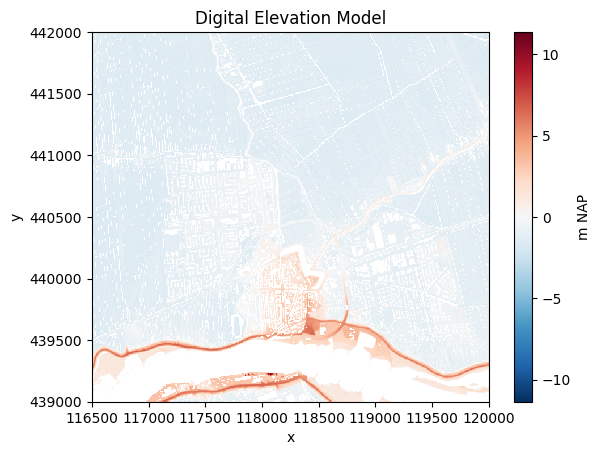

In [108]:
# download a geohydrological layer model (regis)
regis_ds = nlmod.read.regis.download_regis(extent, cachedir=cachedir, cachename='regis')

# download surface water levels (bgt)
bgt_gdf = nlmod.read.bgt.download_bgt(extent=extent, cachedir=cachedir, cachename='bgt')

# download DEM (ahn)
ahn = nlmod.read.ahn.download_ahn(extent=extent, cachedir=cachedir, cachename='ahn')

# plot the digital elevation model
f, ax = plt.subplots()
ahn.plot(ax=ax, cbar_kwargs={'label':'m NAP'})
ax.set_title('Digital Elevation Model')
f.savefig(figdir+f'/{model_name}_dem.png')

### Discretize

INFO:nlmod.dims.base.to_model_ds:resample layer model data to structured modelgrid
INFO:nlmod.dims.layers.get_kh_kv:kv and kh both undefined in layer HLc
INFO:nlmod.dims.layers._fill_var:Filling 7594 values in active cells of kh by multipying kv with an anisotropy of 10
INFO:nlmod.dims.layers._fill_var:Filling 16762 values in active cells of kv by dividing kh by an anisotropy of 10
INFO:nlmod.dims.layers._fill_var:Filling 1050 values in active cells of kh with a value of 1.0 m/day
INFO:nlmod.dims.layers._fill_var:Filling 1050 values in active cells of kv with a value of 0.1 m/day


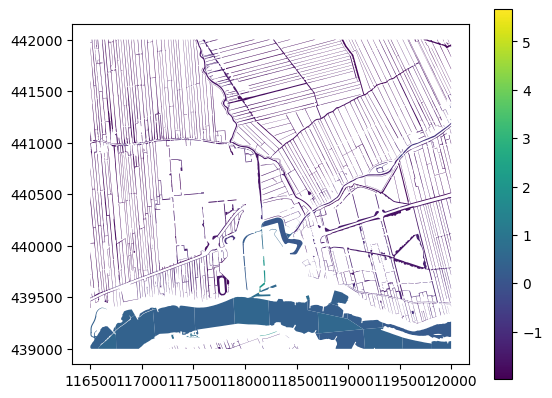

In [113]:
dx, dy = 100., 100. # cellsize

# discretise layer model (regis) to model dimensions
ds = nlmod.to_model_ds(regis_ds, model_name, model_ws, delr=dx, delc=dy)

# add DEM (ahn) to model dataset
ds.update(nlmod.read.ahn.discretize_ahn(ds, ahn))

# specify recharge
ds['recharge'] = xr.ones_like(ds['top']) * 0.0007 # 0.7 mm/day

# add minimum digital elevation to use as surface water stage
bgt_gdf = nlmod.gwf.add_min_ahn_to_gdf(bgt_gdf, ahn, buffer=5.0, column="stage").dropna(subset='stage')
bgt_gdf.plot('stage', legend=True)

# set model time settings
tmin = "2010-01-01"
tmax = "2020-01-01"
freq = "14D"
t = date_range(tmin, tmax, freq=freq)
ds = nlmod.time.set_ds_time(ds, start=3652, time=t, steady_start=True)

### Build groundwater flow model

In [84]:
# build the modflow6 gwf model
gwf = nlmod.gwf.ds_to_gwf(ds)

# discretize surface water data
sfw_grid = nlmod.grid.gdf_to_grid(
    bgt_gdf, gwf, cachedir=ds.cachedir, cachename="sfw_grid.pklz"
)

# add bed resistance to calculate conductance
bed_resistance = 10.0  # days
sfw_grid["cond"] = sfw_grid.area / bed_resistance
sfw_grid.set_index("cellid", inplace=True)

# build stress period data for RIV package
drn_spd = nlmod.gwf.surface_water.build_spd(sfw_grid, "DRN", ds)

# flopy is used to construct the DRN package directly
drn = fp.mf6.ModflowGwfdrn(gwf, stress_period_data=drn_spd)

INFO:nlmod.sim.sim.sim:creating mf6 SIM
INFO:nlmod.sim.sim.tdis:creating mf6 TDIS
INFO:nlmod.sim.sim.ims:creating mf6 IMS
INFO:nlmod.gwf.gwf.gwf:creating mf6 GWF
INFO:nlmod.gwf.gwf._dis:creating mf6 DIS
INFO:nlmod.gwf.gwf.npf:creating mf6 NPF
INFO:nlmod.gwf.gwf.ic:creating mf6 IC
INFO:nlmod.gwf.gwf.oc:creating mf6 OC
INFO:nlmod.gwf.gwf.rch:creating mf6 RCH
INFO:nlmod.cache.decorator:using cached data -> sfw_grid.pklz


Building stress period data DRN: 100%|██████████| 4171/4171 [00:01<00:00, 2096.12it/s]


In [77]:
# build and run model
nlmod.sim.write_and_run(gwf, ds, silent=True)

INFO:nlmod.sim.sim.write_and_run:write model dataset to cache
INFO:nlmod.sim.sim.write_and_run:write modflow files to model workspace
INFO:nlmod.sim.sim.write_and_run:run model


### Post-processing

Plotting the average head in REGIS layer PZWAz3

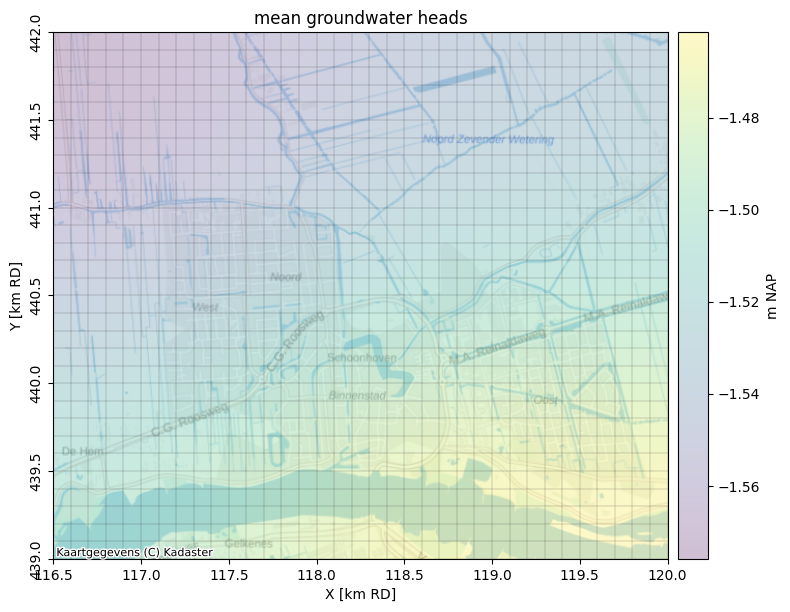

In [118]:
# load the computed heads
head = nlmod.gwf.output.get_heads_da(ds)

# plot on map
ax = nlmod.plot.map_array(
    head.sel(layer="PZWAz3").mean(dim="time"),
    ds,
    alpha=0.25,
    background=True,
    colorbar_label='m NAP',
    figsize=(8,8),
    title='mean groundwater heads'
)
ax.get_figure().savefig(figdir + f'/{model_name}_heads.png')